# S&P500

In [69]:
import yfinance as yf
import datetime
import pandas as pd

tickers = ['^GSPC', '^IXIC','^KS200', '^N225', '^GDAXI']

hourly_signal = {}
daily_signal = {}

for ticker in tickers:

    net = yf.Ticker(ticker)

    now = datetime.datetime.now()
    substract_days = datetime.timedelta(days=500)
    n_days_ago = now - substract_days    
    pred_start = pd.to_datetime(n_days_ago)
    pred_end = pd.to_datetime(now)

    start_date, end_date = pred_start, pred_end
    daily_signals_df = net.history(start=start_date, end=end_date, interval='1d', back_adjust=True, auto_adjust=True, prepost=False)
    hourly_signals_df = net.history(start=start_date, end=end_date, interval='1h', back_adjust=True, auto_adjust=True, prepost=True)
    
    daily_signal[ticker] = daily_signals_df['Close']
    hourly_signal[ticker] = hourly_signals_df['Close']

In [70]:
def get_df (name = '^GSPC'):
    df = pd.DataFrame(hourly_signal[name])
    df.columns = ['Close']
    df = df.dropna()
    return df

tickers = ['^GSPC', '^IXIC','^KS200', '^N225', '^GDAXI']

df_list = []
for ticker in tickers:
    df = get_df(ticker)
    df_list.append(df)

SP500 = df_list[0]
NASDAQ = df_list[1]
KS200 = df_list[2]
NI = df_list[3]
DAX = df_list[4]

SP500

,Close
2021-01-11 09:30:00-05:00,3808.939941
2021-01-11 10:30:00-05:00,3811.350098
2021-01-11 11:30:00-05:00,3811.800049
2021-01-11 12:30:00-05:00,3810.030029
2021-01-11 13:30:00-05:00,3799.010010
...,...
2022-05-25 13:30:00-04:00,3973.350098
2022-05-25 14:30:00-04:00,3990.260010
2022-05-25 15:30:00-04:00,3978.500000
2022-05-25 16:00:00-04:00,3978.730000


In [71]:
IDX_list = [SP500, NASDAQ, KS200, NI, DAX]
name_list = ['SP500', 'NASDAQ', 'KS200', 'NI', 'DAX']

for idx, name in zip (IDX_list, name_list):
    print(name +' : ' + str(idx.shape))

SP500 : (3066, 1)
NASDAQ : (3121, 1)
KS200 : (2359, 1)
NI : (2004, 1)
DAX : (3508, 1)


In [72]:
SP500_cp=SP500.copy()
SP500_cp.index.name="Date"

df=SP500_cp
df=df[(pd.DatetimeIndex(df.index)<'2022-05-25')&(pd.DatetimeIndex(df.index)>'2021-01-10')&(pd.DatetimeIndex(df.index).hour<17)]
df

,Close
Date,
2021-01-11 09:30:00-05:00,3808.939941
2021-01-11 10:30:00-05:00,3811.350098
2021-01-11 11:30:00-05:00,3811.800049
2021-01-11 12:30:00-05:00,3810.030029
2021-01-11 13:30:00-05:00,3799.010010
...,...
2022-05-24 12:30:00-04:00,3904.800049
2022-05-24 13:30:00-04:00,3925.340088
2022-05-24 14:30:00-04:00,3931.239990


In [73]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [74]:
scaler = MinMaxScaler()
scale_col=['Close']
df_scaled=scaler.fit_transform(df)

df_scaled=pd.DataFrame(df_scaled)
df_scaled.columns=scale_col

df_scaled

,Close
0,0.087009
1,0.089200
2,0.089609
3,0.088000
4,0.077982
...,...
2760,0.174155
2761,0.192827
2762,0.198191
2763,0.209609


In [82]:
train = df_scaled[:-24]
test = df_scaled[-24:]
print(train.shape,test.shape)

(2741, 1) (24, 1)


In [83]:
X_train=train[:-8]
y_train=train[8:]
print(X_train.shape,y_train.shape)

(2733, 1) (2733, 1)


In [84]:
X_test=test[:-8]
y_test=test[8:]
print(X_test.shape,y_test.shape)

(16, 1) (16, 1)


In [85]:
# window_size=8 : S&9500 1일 영업시간(9:30~16:00) 동안의 dataset
def make_dataset(data,label,window_size=8):
    feature_list=[]
    label_list=[]
    for i in range(len(data)-window_size):
        feature_list.append(np.array(data[i:i+window_size]))
        label_list.append(np.array(label.iloc[i]))
    return np.array(feature_list), np.array(label_list)

In [86]:
from sklearn.model_selection import train_test_split

# train dataset
X_train, y_train=make_dataset(X_train,y_train,8)

# train, validation set 생성
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.1)

# test dataset
X_test,y_test=make_dataset(X_test,y_test,8)
X_test.shape,y_test.shape
# ((8, 8, 1), (8, 1))

In [87]:
#X_test,y_test=make_dataset(X_test,y_test,8)
#print(X_test.shape,y_test.shape)

(8, 8, 1) (8, 1)


In [12]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras.layers import LSTM

from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=10,verbose=1)
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

model=tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64,return_sequences=True,input_shape=(X_train.shape[1],1)),
    tf.keras.layers.LSTM(32,return_sequences=False),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

In [13]:
model.compile(loss='mean_squared_error', optimizer='adam')
hist=model.fit(X_train,y_train,epochs=500,batch_size=5,validation_data=(X_val,y_val),callbacks=[checkpoint,earlystopping])

Epoch 1/500
489/491 [============================>.] - ETA: 0s - loss: 0.0058
Epoch 1: val_loss improved from inf to 0.00088, saving model to model.h5
491/491 [==============================] - 9s 10ms/step - loss: 0.0058 - val_loss: 8.7546e-04
Epoch 2/500
491/491 [==============================] - ETA: 0s - loss: 9.5361e-04
Epoch 2: val_loss improved from 0.00088 to 0.00080, saving model to model.h5
491/491 [==============================] - 4s 8ms/step - loss: 9.5361e-04 - val_loss: 8.0102e-04
Epoch 3/500
486/491 [============================>.] - ETA: 0s - loss: 8.3906e-04
Epoch 3: val_loss improved from 0.00080 to 0.00071, saving model to model.h5
491/491 [==============================] - 4s 9ms/step - loss: 8.4328e-04 - val_loss: 7.0730e-04
Epoch 4/500
485/491 [============================>.] - ETA: 0s - loss: 7.7113e-04
Epoch 4: val_loss did not improve from 0.00071
491/491 [==============================] - 4s 8ms/step - loss: 7.7098e-04 - val_loss: 8.5561e-04
Epoch 5/500
488/4

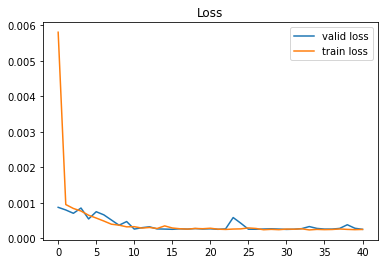

In [14]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(hist.history['val_loss'],label='valid loss')
plt.plot(hist.history['loss'],label='train loss')
plt.legend()
plt.show()

#plt.savefig('fig01.png',format='png',dpi=300)

In [15]:
y_pred=model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

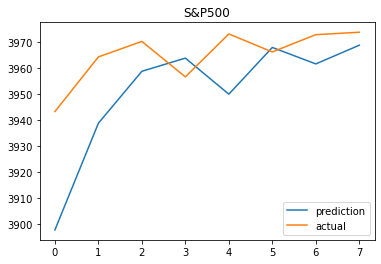

In [16]:
plt.title('S&P500')
plt.plot(y_pred,label='prediction')
plt.plot(y_test,label='actual')
plt.legend()
#plt.show()

plt.savefig('LSTM_fig02.png',format='png',dpi=300)

In [25]:
result = pd.DataFrame(index=test.index[16:])
result.reset_index(inplace=True)

result['y_pred'] = y_pred

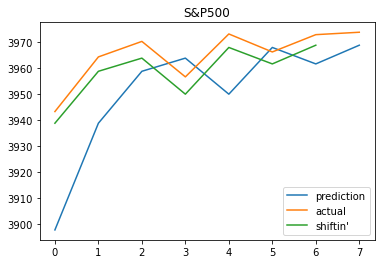

In [26]:
plt.title('S&P500')
plt.plot(y_pred,label='prediction')
plt.plot(y_test,label='actual')

shift = result.y_pred.shift(-1).values
plt.plot(shift,label="shiftin'")

plt.legend()
#plt.show()

plt.savefig('LSTM_fig03.png',format='png',dpi=300)

In [28]:
# RMSE

from sklearn.metrics import mean_squared_error 

MSE = mean_squared_error(y_test, y_pred) 
round(np.sqrt(MSE),2)

21.23

In [29]:
# MAPE

def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
round(MAPE(y_test, y_pred)*100,2)

41.36

# BTC

In [30]:
BTC = pd.read_csv('C:/fintech6/_project2/src/BTC.csv',infer_datetime_format=True,index_col='Unnamed: 0')
BTC

,open,high,low,close,volume,value
2019-09-06 21:00:00+00:00,10837.073450,10892.000000,10825.000000,10826.240000,13.028313,141488.509446
2019-09-06 22:00:00+00:00,10826.240000,10851.990000,10763.968517,10803.422690,26.329976,284421.274696
2019-09-06 23:00:00+00:00,10803.410000,10850.000000,10803.410000,10827.649995,11.192036,121318.460494
2019-09-07 00:00:00+00:00,10833.520000,10879.270000,10833.520000,10843.160000,7.257861,78828.225009
2019-09-07 01:00:00+00:00,10841.006105,10856.282376,10827.649995,10855.177197,5.160667,55951.010868
...,...,...,...,...,...,...
2022-05-01 04:00:00+00:00,38366.850000,38531.871679,38366.850000,38531.871679,0.017207,661.545067
2022-05-01 05:00:00+00:00,38453.599000,38453.599000,38379.200000,38379.200000,0.019895,764.321204
2022-05-01 06:00:00+00:00,38379.200000,38445.961000,38332.268000,38382.931000,0.153709,5905.244381
2022-05-01 07:00:00+00:00,38301.414000,38422.006800,38259.735000,38399.064000,0.520722,19982.987904


In [31]:
BTC = BTC[BTC.index >= '2019-09-07']
BTC = BTC[BTC.index < '2022-05-01']
BTC

,open,high,low,close,volume,value
2019-09-07 00:00:00+00:00,10833.520000,10879.270000,10833.520000,10843.160000,7.257861,7.882823e+04
2019-09-07 01:00:00+00:00,10841.006105,10856.282376,10827.649995,10855.177197,5.160667,5.595101e+04
2019-09-07 02:00:00+00:00,10855.177197,10855.177197,10282.054053,10430.460000,187.320146,1.960596e+06
2019-09-07 03:00:00+00:00,10423.205919,10433.354008,10350.000000,10354.800000,22.704425,2.361178e+05
2019-09-07 04:00:00+00:00,10361.777139,10403.800000,10350.000000,10390.510000,27.535793,2.857438e+05
...,...,...,...,...,...,...
2022-04-30 19:00:00+00:00,38634.148000,38669.788800,38620.169000,38620.169000,0.333999,1.290469e+04
2022-04-30 20:00:00+00:00,38620.169000,38695.574000,38620.169000,38620.169000,0.217057,8.385589e+03
2022-04-30 21:00:00+00:00,38620.169000,38757.092732,38620.169000,38620.169000,1.963208,7.588252e+04
2022-04-30 22:00:00+00:00,38620.169000,38685.101000,38496.827930,38546.263000,1.444348,5.572170e+04


In [32]:
BTC = BTC[['close']]
BTC

,close
2019-09-07 00:00:00+00:00,10843.160000
2019-09-07 01:00:00+00:00,10855.177197
2019-09-07 02:00:00+00:00,10430.460000
2019-09-07 03:00:00+00:00,10354.800000
2019-09-07 04:00:00+00:00,10390.510000
...,...
2022-04-30 19:00:00+00:00,38620.169000
2022-04-30 20:00:00+00:00,38620.169000
2022-04-30 21:00:00+00:00,38620.169000
2022-04-30 22:00:00+00:00,38546.263000


In [33]:
scaler = MinMaxScaler()
scale_col=['close']
BTC_scaled=scaler.fit_transform(BTC)

BTC_scaled=pd.DataFrame(BTC_scaled)
BTC_scaled.columns=scale_col

BTC_scaled

,close
0,0.099377
1,0.099566
2,0.092912
3,0.091727
4,0.092286
...,...
19983,0.534525
19984,0.534525
19985,0.534525
19986,0.533367


In [34]:
train = BTC_scaled[:-72]
test = BTC_scaled[-72:]
print(train.shape,test.shape)

(19916, 1) (72, 1)


In [35]:
X_train=train[:-24]
y_train=train[24:]
print(X_train.shape,y_train.shape)

(19892, 1) (19892, 1)


In [36]:
X_test=test[:-24]
y_test=test[24:]
print(X_test.shape,y_test.shape)

(48, 1) (48, 1)


In [37]:
# window_size=24
def make_dataset(data,label,window_size=24):
    feature_list=[]
    label_list=[]
    for i in range(len(data)-window_size):
        feature_list.append(np.array(data[i:i+window_size]))
        label_list.append(np.array(label.iloc[i]))
    return np.array(feature_list), np.array(label_list)

In [38]:
# train dataset
X_train, y_train=make_dataset(X_train,y_train,24)

# train, validation set 생성
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2)

# test dataset
X_test,y_test=make_dataset(X_test,y_test,24)
X_test.shape,y_test.shape

((24, 24, 1), (24, 1))

In [39]:
model=tf.keras.models.Sequential([
    tf.keras.layers.LSTM(192,return_sequences=True,input_shape=(X_train.shape[1],1)),
    tf.keras.layers.LSTM(96,return_sequences=False),
    tf.keras.layers.Dense(48),
    tf.keras.layers.Dense(1)
])

In [40]:
model.compile(loss='mean_squared_error', optimizer='adam')
hist=model.fit(X_train,y_train,epochs=500,batch_size=5,validation_data=(X_val,y_val),callbacks=[earlystopping])

Epoch 1/500
3179/3179 [==============================] - 86s 26ms/step - loss: 4.0229e-04 - val_loss: 1.4554e-04
Epoch 2/500
3179/3179 [==============================] - 88s 28ms/step - loss: 1.2263e-04 - val_loss: 7.1634e-05
Epoch 3/500
3179/3179 [==============================] - 91s 29ms/step - loss: 8.9735e-05 - val_loss: 4.6118e-05
Epoch 4/500
3179/3179 [==============================] - 93s 29ms/step - loss: 8.4878e-05 - val_loss: 1.0399e-04
Epoch 5/500
3179/3179 [==============================] - 98s 31ms/step - loss: 7.5303e-05 - val_loss: 1.0288e-04
Epoch 6/500
3179/3179 [==============================] - 98s 31ms/step - loss: 7.2871e-05 - val_loss: 1.1280e-04
Epoch 7/500
3179/3179 [==============================] - 96s 30ms/step - loss: 6.7433e-05 - val_loss: 4.4437e-05
Epoch 8/500
3179/3179 [==============================] - 101s 32ms/step - loss: 6.5784e-05 - val_loss: 1.3168e-04
Epoch 9/500
3179/3179 [==============================] - 98s 31ms/step - loss: 6.4426e-05 - val

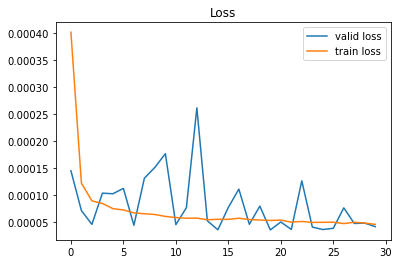

In [41]:
plt.title('Loss')
plt.plot(hist.history['val_loss'],label='valid loss')
plt.plot(hist.history['loss'],label='train loss')
plt.legend()
plt.show()

#plt.savefig('LSTM_fig04.png',format='png',dpi=300)

In [42]:
y_pred=model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

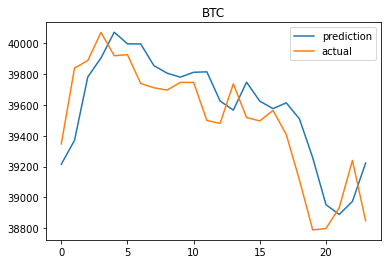

In [43]:
plt.title('BTC')
plt.plot(y_pred,label='prediction')
plt.plot(y_test,label='actual')
plt.legend()
plt.show()

#plt.savefig('LSTM_fig05.png',format='png',dpi=300)

In [45]:
result = pd.DataFrame(index=test.index[48:])
result.reset_index(inplace=True)

result['y_pred'] = y_pred

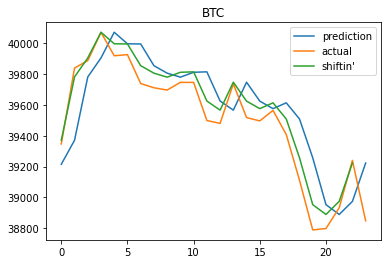

In [47]:
plt.title('BTC')
plt.plot(y_pred,label='prediction')
plt.plot(y_test,label='actual')

shift = result.y_pred.shift(-1).values
plt.plot(shift,label="shiftin'")

plt.legend()
plt.show()

#plt.savefig('LSTM_fig06.png',format='png',dpi=300)

In [50]:
# RMSE

MSE = mean_squared_error(y_test, y_pred) 
RMSE=np.sqrt(MSE)
round(RMSE,2)

231.28

In [51]:
# MAPE

def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
round(MAPE(y_test, y_pred)*100,2)

48.81